In [32]:
import pandas as pd
import torch
from torch.optim import AdamW  # Import PyTorch's AdamW

from torch.utils.data import DataLoader, Dataset
#from transformers import BertTokenizer, BertForSequenceClassification
from transformers import LongformerTokenizer, LongformerForSequenceClassification, AdamW

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [84]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ADL-Hallucination-Detection')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Load the datasets
train_data = pd.read_csv("cnndm/train_data_base.csv", sep=';')
valid_data = pd.read_csv("cnndm/valid_data_base.csv", sep=';')
test_data = pd.read_csv("cnndm/test_data_base.csv", sep=';')

In [34]:
print(train_data.isna().sum())
missing_rows = train_data[train_data.isna().any(axis=1)]


Unnamed: 0    0
article       0
highlights    0
label         0
dtype: int64


In [6]:
train_data.head()

,Unnamed: 0,article,highlights,label
0,1,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,0
1,2,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,0
2,3,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",0
3,4,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",0
4,5,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",0


In [ ]:

# Load tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

# Load Longformer model for classification
model = LongformerForSequenceClassification.from_pretrained(
    "allenai/longformer-base-4096",
    num_labels=2  # Binary classification
)

# Check model details
print(model.config)


In [ ]:
# # Load the tokenizer and model
# tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
# model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

c:\Users\mabsa\anaconda3\envs\adl_project\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mabsa\.cache\huggingface\hub\models--prajjwal1--bert-tiny. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


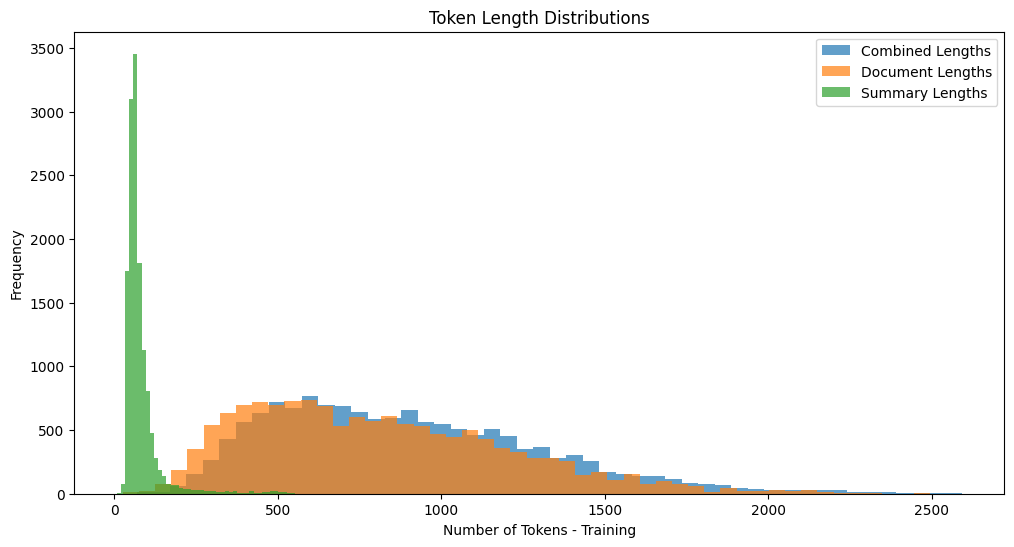

       Document Lengths  Summary Lengths  Combined Lengths
count      13952.000000     13952.000000      13952.000000
mean         806.338159        81.510464        890.848624
std          400.513897        60.774140        409.056411
min           27.000000         8.000000         70.000000
25%          488.000000        54.000000        571.000000
50%          747.000000        65.000000        831.000000
75%         1069.250000        87.000000       1153.000000
max         2496.000000       642.000000       2593.000000


In [36]:
# Tokenize and calculate token lengths
def calculate_lengths(data, tokenizer, column_name):
    lengths = []
    for text in data[column_name]:
        tokens = tokenizer.tokenize(text)
        lengths.append(len(tokens))
    return lengths

# Calculate token lengths for documents and summaries
doc_lengths = calculate_lengths(train_data, tokenizer, column_name='article')
summ_lengths = calculate_lengths(train_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths = [d + s + 3 for d, s in zip(doc_lengths, summ_lengths)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df = pd.DataFrame({
    'Document Lengths': doc_lengths,
    'Summary Lengths': summ_lengths,
    'Combined Lengths': combined_lengths
})

# Plot distributions
plt.figure(figsize=(12, 6))
plt.hist(lengths_df['Combined Lengths'], bins=50, alpha=0.7, label='Combined Lengths')
plt.hist(lengths_df['Document Lengths'], bins=50, alpha=0.7, label='Document Lengths')
plt.hist(lengths_df['Summary Lengths'], bins=50, alpha=0.7, label='Summary Lengths')
#plt.axvline(x=512, color='red', linestyle='--', label='Max Length (512)')
plt.xlabel('Number of Tokens - Training')
plt.ylabel('Frequency')
plt.legend()
plt.title('Token Length Distributions')
plt.show()

# Print statistics
print(lengths_df.describe())


In [39]:
# Calculate token lengths for documents and summaries
doc_lengths_test = calculate_lengths(test_data, tokenizer, column_name='article')
summ_lengths_test = calculate_lengths(test_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths_test = [d + s + 3 for d, s in zip(doc_lengths_test, summ_lengths_test)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df_test = pd.DataFrame({
    'Document Lengths': doc_lengths_test,
    'Summary Lengths': summ_lengths_test,
    'Combined Lengths': combined_lengths_test
})

print(lengths_df_test.describe())



       Document Lengths  Summary Lengths  Combined Lengths
count       1986.000000      1986.000000       1986.000000
mean         806.749245        65.001511        874.750755
std          448.546224        52.270875        458.887068
min          104.000000        14.000000        127.000000
25%          441.000000        39.000000        505.750000
50%          732.000000        52.000000        798.000000
75%         1090.000000        72.000000       1164.750000
max         2965.000000       519.000000       3050.000000


In [41]:
# Calculate token lengths for documents and summaries
doc_lengths_valid = calculate_lengths(valid_data, tokenizer, column_name='article')
summ_lengths_valid = calculate_lengths(valid_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths_valid = [d + s + 3 for d, s in zip(doc_lengths_valid, summ_lengths_valid)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df_valid = pd.DataFrame({
    'Document Lengths': doc_lengths_valid,
    'Summary Lengths': summ_lengths_valid,
    'Combined Lengths': combined_lengths_valid
})

print(lengths_df_valid.describe())

       Document Lengths  Summary Lengths  Combined Lengths
count       1992.000000      1992.000000       1992.000000
mean         828.542169        65.669177        897.211345
std          444.207719        56.287804        454.320465
min          114.000000        11.000000        133.000000
25%          474.000000        38.000000        532.750000
50%          760.500000        52.000000        826.000000
75%         1107.250000        71.000000       1182.250000
max         2287.000000       548.000000       2648.000000


In [48]:
print((lengths_df["Document Lengths"] > 1024).sum())
print((lengths_df_test["Document Lengths"] > 1024).sum())
print((lengths_df_valid["Document Lengths"] > 1024).sum())
print()

print((lengths_df["Document Lengths"] > 2048).sum())
print((lengths_df_test["Document Lengths"] > 2048).sum())
print((lengths_df_valid["Document Lengths"] > 2048).sum())

3908
588
594

90
24
18


In [49]:
print((lengths_df["Combined Lengths"] > 1024).sum())
print((lengths_df_test["Combined Lengths"] > 1024).sum())
print((lengths_df_valid["Combined Lengths"] > 1024).sum())
print()

print((lengths_df["Combined Lengths"] > 2048).sum())
print((lengths_df_test["Combined Lengths"] > 2048).sum())
print((lengths_df_valid["Combined Lengths"] > 2048).sum())

4716
682
700

157
33
32


In [50]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.examples = []
        self.skipped_count = 0  # Counter for rows skipped due to document length
        self.skipped_bc_chunk = 0  # Counter for rows skipped due to chunking issues

        self._create_examples()

    def _create_examples(self):
        for _, row in self.data.iterrows():
            doc, summ, label = row['article'], row['highlights'], row['label']

            # Tokenize document and summary
            doc_tokens = self.tokenizer.tokenize(doc)
            summ_tokens = self.tokenizer.tokenize(summ)

            # Ensure document fits within max_length alone
            if len(doc_tokens) + 3 > self.max_length:  # [CLS] doc_tokens [SEP]
                self.skipped_count += 1
                continue

            # Function to check if a chunk fits within max_length
            def chunk_fits(tokens_chunk):
                return len(doc_tokens) + len(tokens_chunk) + 3 <= self.max_length

            # Case 1: Check if the full summary fits
            if chunk_fits(summ_tokens):
                input_ids, attention_mask = self._create_input(doc_tokens, summ_tokens)
                self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
            else:
                # Case 2: Try splitting into halves
                mid = len(summ_tokens) // 2
                if chunk_fits(summ_tokens[:mid]) and chunk_fits(summ_tokens[mid:]):
                    for chunk in [summ_tokens[:mid], summ_tokens[mid:]]:
                        input_ids, attention_mask = self._create_input(doc_tokens, chunk)
                        self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
                else:
                    # Case 3: Try splitting into thirds
                    third = len(summ_tokens) // 3
                    chunks = [summ_tokens[:third], summ_tokens[third:2 * third], summ_tokens[2 * third:]]
                    if all(chunk_fits(chunk) for chunk in chunks):
                        for chunk in chunks:
                            input_ids, attention_mask = self._create_input(doc_tokens, chunk)
                            self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
                    else:
                        # Case 4: Skip if none of the strategies work
                        self.skipped_bc_chunk += 1

    def _create_input(self, doc_tokens, summ_tokens):
        input_ids = [self.tokenizer.cls_token_id] + \
                    self.tokenizer.convert_tokens_to_ids(doc_tokens) + \
                    [self.tokenizer.sep_token_id] + \
                    self.tokenizer.convert_tokens_to_ids(summ_tokens) + \
                    [self.tokenizer.sep_token_id]

        attention_mask = [1] * len(input_ids)

        # Pad if necessary
        if len(input_ids) < self.max_length:
            pad_length = self.max_length - len(input_ids)
            input_ids += [self.tokenizer.pad_token_id] * pad_length
            attention_mask += [0] * pad_length

        return input_ids, attention_mask

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        return {
            "input_ids": torch.tensor(example["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(example["attention_mask"], dtype=torch.long),
            "label": torch.tensor(example["label"], dtype=torch.long)
        }


In [51]:
# wir schauen uns mal wie viele rausfliegen und wie die token lengths verteilt sind

In [ ]:
# Parameters
MAX_LEN = 2048 # das setzen wir als balance zwischen wie viele padding brauchen und wie viele rausfallen

# Prepare datasets
train_dataset = CustomDataset(train_data, tokenizer, max_length=MAX_LEN)
valid_dataset = CustomDataset(valid_data, tokenizer, max_length=MAX_LEN)
test_dataset = CustomDataset(test_data, tokenizer, max_length=MAX_LEN)


In [29]:
print(f'Train: {train_dataset.skipped_count}/{train_data.shape[0]} ~ {train_dataset.skipped_count/train_data.shape[0] * 100} %')
print(f'Test: {test_dataset.skipped_count}/{test_data.shape[0]} ~ {test_dataset.skipped_count/test_data.shape[0] * 100} %')
print(f'Valid: {valid_dataset.skipped_count}/{valid_data.shape[0]} ~ {valid_dataset.skipped_count/valid_data.shape[0] * 100} %')

Train: 10196/13952 ~ 73.07912844036697 %
Test: 1356/1986 ~ 68.27794561933534 %
Valid: 1428/1992 ~ 71.6867469879518 %


In [ ]:
print(f'Train: {train_dataset.skipped_bc_chunk}/{train_data.shape[0]} ~ {train_dataset.skipped_bc_chunk/train_data.shape[0] * 100} %')
print(f'Test: {test_dataset.skipped_bc_chunk}/{test_data.shape[0]} ~ {test_dataset.skipped_bc_chunk/test_data.shape[0] * 100} %')
print(f'Valid: {valid_dataset.skipped_bc_chunk}/{valid_data.shape[0]} ~ {valid_dataset.skipped_bc_chunk/valid_data.shape[0] * 100} %')

In [ ]:
BATCH_SIZE = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [113]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        losses.append(loss.item())

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), sum(losses) / len(losses) # TODO hier vielleicht AUC?



In [114]:
def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            losses.append(loss.item())

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), sum(losses) / len(losses)


In [115]:
EPOCHS = 50  # Maximum number of epochs
PATIENCE = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
early_stopping_counter = 0  # Tracks epochs without improvement

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Train for one epoch
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Evaluate on validation set
    val_acc, val_loss = eval_model(model, valid_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset counter if performance improves
        torch.save(model.state_dict(), 'best_model_state.bin')  # Save the best model
        print("Validation performance improved. Model saved.")
    else:
        early_stopping_counter += 1  # Increment counter if no improvement
        print(f"No improvement. Early stopping counter: {early_stopping_counter}/{PATIENCE}")

    # Stop training if early stopping criteria are met
    if early_stopping_counter >= PATIENCE:
        print("Early stopping triggered. Training stopped.")
        break

# Load the best model after training
model.load_state_dict(torch.load('best_model_state.bin'))


Epoch 1/3
----------
Train loss: 0.6129013518534744 | Train accuracy: 0.6867244829886591


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))

test_acc, test_loss = eval_model(model, test_loader, criterion, device)
print(f'Test loss: {test_loss} | Test accuracy: {test_acc}')

# Classification report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))
